In [1]:
# matplotlib
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# statistics
import numpy as np
from scipy import signal

# object support
import copy

# time keeping
import time
from datetime import timedelta

# data munging
import random, string
import pandas as pd

# operating system
import os
import glob
# tensorflow
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# keras support
from keras.models import model_from_yaml

import glob as glob

In [2]:
class Profile:
    def __init__(self,std,im_size):
        self.mid_pixel = int(im_size/2) # 128/2
        self.x, self.y = self.mid_pixel, self.mid_pixel
        self.im_size = im_size
        self.std = std
        self.noise = False
        self.lam = 0.1133929878
        
        gkern1d = signal.gaussian(self.im_size, std=std).reshape(self.im_size, 1)
        self.im = np.outer(gkern1d, gkern1d)
        
        self.im_lrud  = None
        self.im_lr = None
        self.im_ud = None

    def __repr__(self):
        """
        print cluster metadata
        """
        return str(self.im)
    
    def to_pandas(self):
        """
        convert metadata (as recarray) to pandas DataFrame
        """
        self.meta = pd.DataFrame(self.meta)
        return
    
    def add_noise(self):
        """
        add Poisson noise to cluster im matrix
        """
        self.noise = np.random.poisson(lam=self.lam, size=self.im.shape)
        self.im += self.noise
        return
        
    def shift(self):
        """
        shift cluster randomly within bounds of im
        """
        """
        shift cluster randomly within bounds of im
        """
        r = self.std
        mid = self.mid_pixel #center pixel index of 384x384 image
        delta = self.im_size - self.mid_pixel - r - 10
        
        x = np.random.randint(low=-1*delta,high=delta,size=1)[0]
        y = np.random.randint(low=-1*delta,high=delta,size=1)[0]

        self.x += x
        self.y += y
        im_shift = np.roll(self.im,shift=y,axis=0)
        self.im = np.roll(im_shift,shift=x,axis=1)
        
        return 
    
    def plot(self,spath='../figs/profile/'):
        """
        plot image
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(self.im,interpolation='none',cmap='viridis')
        
        ticks = np.arange(0,self.size,50)
        plt.xticks(ticks),plt.yticks(ticks)

        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.12)

        plt.colorbar(im, cax=cax)
        # plt.show()
        plt.close()
        
        return None

    def flip_lr(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1
        
        im_lr = np.fliplr(self.im)
        im_c_lr = np.flipud(im_c)
        
        self.im_lr = im_lr
        self.x_lr, self.y_lr = [val[0] for val in np.nonzero(im_c_lr)]
        
        self.im = im_lr
        self.x, self.y = self.x_lr, self.y_lr
        return None

    def flip_ud(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1

        im_ud = np.flipud(self.im)
        im_c_ud = np.fliplr(im_c)
        
        self.im_ud = im_ud
        self.x_ud, self.y_ud = [val[0] for val in np.nonzero(im_c_ud)]
        
        self.im = im_ud
        self.x, self.y = self.x_ud, self.y_ud
        return None
    
    def flip_lrud(self):
        im_c = np.zeros((self.im_size,self.im_size))
        im_c[self.x,self.y] = 1
        
        im_lrud = np.fliplr(np.flipud(self.im))
        im_c_lrud = np.flipud(np.fliplr(im_c))
        
        self.im_lrud = im_lrud
        self.x_lrud, self.y_lrud = [val[0] for val in np.nonzero(im_c_lrud)]
        
        self.im = im_lrud
        self.x, self.y = self.x_lrud, self.y_lrud
        return None
    
def create_set(set_size=1000,im_size=128,noise=True,shift=True,flip=True):
    dataset = []
    for i in range(set_size):
        std = np.random.randint(low=2,high=15,size=1)
        x = Profile(std=std,im_size=im_size)
        if noise:
            x.add_noise()
        if shift:
            x.shift()
        
        if flip:
            # make copy of original profile
            x_copy = copy.copy(x)

            # flip all left/right
            x.flip_lr()
            x_lr = copy.copy(x)

            # flip all up/down
            x.flip_ud()
            x_ud = copy.copy(x)

            # flip all left/right and up/down
            #x.flip_lrud()
         
            
            dataset.extend([x_copy,x_lr,x_ud])
            
        else:
            dataset.append(x)
    return np.array(dataset)

def load_dataset(dataset,norm=True):
    # fit the keras model on the dataset
    size = len(dataset)
    data = np.array([prof.im for prof in dataset])
    labels = np.array([(prof.x,prof.y,prof.std[0]) for prof in dataset])

    idx = np.arange(0,size,1)
    #train_idx = np.delete(idx, test_idx)
    train_idx = idx
    
    im_size = dataset[0].im.shape[0]
    if norm:
        norm_factor = im_size
    else:
        norm_factor = 1
    
    x_train, y_train = data[train_idx], labels[train_idx]/im_size
    x_train = x_train.reshape(-1, im_size, im_size, 1)
    print("\nDataset loaded.")
    print("Image input shape:", x_train.shape)
    print("Label input shape:", y_train.shape)

    return x_train, y_train


In [3]:
def plot_1tot1(y_train,y_train_model,validation_y,validation_y_model):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(12,3),sharey=False,sharex=False)

    for y, y_model, label in zip([y_train,validation_y],[y_train_model,validation_y_model],['Training data','Validation data']):
        for idx, ax_label in zip([0,1,2], ['X','Y','Sigma']):

            ax[idx].scatter(y[:,idx],y_model[:,idx],s=5,marker=".",label=label)

            lims = [np.min([ax[idx].get_xlim(), ax[idx].get_ylim()]),
                    np.max([ax[idx].get_xlim(), ax[idx].get_ylim()])]
            ax[idx].plot(lims, lims, 'k-', alpha=1, zorder=0,lw=1)
            ax[idx].set_aspect('equal')
            ax[idx].set_xlim(lims), ax[idx].set_ylim(lims)
            ax[idx].set_xlabel('Truth {}'.format(ax_label))
            ax[idx].set_ylabel('Predicted {}'.format(ax_label))
            ax[idx].set_aspect(1)
            ax[idx].tick_params(axis="both",direction="in", pad=-15)

    plt.legend(frameon=False)
    #plt.subplots_adjust(wspace=0.01)
    plt.tight_layout()

    #plt.savefig(spath + '/1to1_center_xy_{}.png'.format(model_id), dpi=200, bbox_inches='tight')
    pad = 0.05 # Padding around the edge of the figure
    dx, dy = 1, 1

    xpad, ypad = dx * pad, dy * pad
    fig.subplots_adjust(left=xpad, right=1-xpad, top=1-ypad, bottom=ypad)
    
    plt.show()

    plt.close()

In [4]:
im_size = 128
set_size = 1000

# create gaussian dataset
dataset = create_set(im_size=im_size,set_size=set_size)

# create training set preview figure
# plot(dataset=dataset, spath=spath)

x_train, y_train = load_dataset(dataset)

validation_split = 0.2
x_train, y_train = load_dataset(dataset)
batch_size = len(dataset)

split_at = int(x_train.shape[0] * (1-validation_split))
validation_x = x_train[split_at:]
validation_y = y_train[split_at:]
validation_data=(validation_x, validation_y)


Dataset loaded.
Image input shape: (3000, 128, 128, 1)
Label input shape: (3000, 3)

Dataset loaded.
Image input shape: (3000, 128, 128, 1)
Label input shape: (3000, 3)


In [5]:
models = glob.glob('../../../crab_models/*')
print(models)

['../../../crab_models/7OSt6', '../../../crab_models/X1wb0', '../../../crab_models/uSkLt', '../../../crab_models/iYHYW', '../../../crab_models/NFLjL', '../../../crab_models/zgtE6', '../../../crab_models/NEuj2', '../../../crab_models/wWXVU', '../../../crab_models/mAeDo', '../../../crab_models/Zi2er', '../../../crab_models/D5aVN', '../../../crab_models/iNM7H', '../../../crab_models/9ma6d', '../../../crab_models/Xzp6l', '../../../crab_models/wzfD4', '../../../crab_models/GtZij', '../../../crab_models/63lOm', '../../../crab_models/uGK3o', '../../../crab_models/negGU', '../../../crab_models/zGKrU', '../../../crab_models/BAclh', '../../../crab_models/o2vjz', '../../../crab_models/XOtSS', '../../../crab_models/4jVLt', '../../../crab_models/JANrn', '../../../crab_models/7dUXK']


19/19 [==============================] - 0s 17ms/step


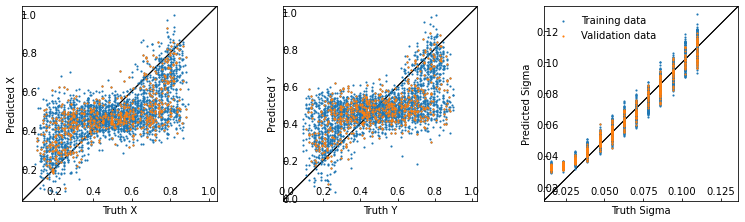

In [7]:
model_path = '../../../crab_models/4jVLt'
new_model = keras.models.load_model(model_path)
y_train_model = new_model.predict(x_train,verbose=1)    

validation_y_model = new_model.predict(validation_x,verbose=1)

plot_1tot1(y_train=y_train,
           y_train_model=y_train_model,
           validation_y=validation_y,
           validation_y_model=validation_y_model)

In [9]:
print("\n***LEARNING START***")
epochs = 1000
start = time.time()
history = new_model.fit(x=x_train[:split_at],
                    y=y_train[:split_at],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_x, validation_y),
                    verbose=2)
print("***LEARNING END***")
elapsed = time.time() - start
print("\nTIME:",str(timedelta(seconds=elapsed)))


***LEARNING START***
Epoch 1/1000
1/1 - 8s - loss: 0.0187 - accuracy: 0.7050 - val_loss: 0.1267 - val_accuracy: 0.7033
Epoch 2/1000
1/1 - 7s - loss: 0.1295 - accuracy: 0.6958 - val_loss: 0.0200 - val_accuracy: 0.6900
Epoch 3/1000
1/1 - 7s - loss: 0.0206 - accuracy: 0.6975 - val_loss: 0.0344 - val_accuracy: 0.6867
Epoch 4/1000
1/1 - 7s - loss: 0.0351 - accuracy: 0.7108 - val_loss: 0.0554 - val_accuracy: 0.6200
Epoch 5/1000
1/1 - 7s - loss: 0.0560 - accuracy: 0.6283 - val_loss: 0.0509 - val_accuracy: 0.6167
Epoch 6/1000
1/1 - 7s - loss: 0.0515 - accuracy: 0.6304 - val_loss: 0.0371 - val_accuracy: 0.6700
Epoch 7/1000
1/1 - 7s - loss: 0.0377 - accuracy: 0.6667 - val_loss: 0.0262 - val_accuracy: 0.6867
Epoch 8/1000
1/1 - 7s - loss: 0.0267 - accuracy: 0.7125 - val_loss: 0.0221 - val_accuracy: 0.6717
Epoch 9/1000
1/1 - 7s - loss: 0.0224 - accuracy: 0.6754 - val_loss: 0.0241 - val_accuracy: 0.6467
Epoch 10/1000
1/1 - 7s - loss: 0.0242 - accuracy: 0.6600 - val_loss: 0.0290 - val_accuracy: 0.66

KeyboardInterrupt: 

In [ ]:
    model.save(model_dir)
    print("Model assets saved to:", model_dir)
    